In [ ]:
from ortools.sat.python import cp_model

def solve(n, adj, l_val, w_val, anchors):
    # Create a CP-SAT model.
    model = cp_model.CpModel()

    # Declare variables for x and y coordinates.
    x_val = [model.NewIntVar(0, cp_model.INT32_MAX, f"x_val{i}") for i in range(n)]
    y_val = [model.NewIntVar(0, cp_model.INT32_MAX, f"y_val{i}") for i in range(n)]

    # Set anchor-based constraints.
    for index in anchors:
        model.Add(y_val[index] == 0)

    # Add adjacency constraints.
    for i, j in adj:
        model.Add(x_val[j] == x_val[i] + l_val[i])
        model.Add(y_val[i] <= y_val[j] - w_val[j] + cp_model.INT32_MAX * (1 - x_val[i] == x_val[j])).OnlyEnforceIf(x_val[i] > 0)
        model.Add(y_val[j] == y_val[i] + w_val[i]).OnlyEnforceIf(y_val[j]>0)
        model.Add(x_val[i] <= x_val[j] - l_val[j] + cp_model.INT32_MAX * (1 - x_val[i] == x_val[j])).OnlyEnforceIf(x_val[i] > 0)
        model.Add(x_val[i] == x_val[j] + l_val[j])
        model.Add(y_val[j] <= y_val[i] - w_val[i] + cp_model.INT32_MAX * (1 - x_val[i] == x_val[j])).OnlyEnforceIf(x_val[j] > 0)
        model.Add(y_val[i] == y_val[j] + w_val[j])
        model.Add(x_val[j] <= x_val[i] - l_val[i] + cp_model.INT32_MAX * (1 - x_val[i] == x_val[j])).OnlyEnforceIf(x_val[j] > 0)
        model.Add(x_val[j] == x_val[i] + l_val[i])

    # Add no-overlap constraints.
    for i in range(n):
        for j in range(i + 1, n):
            if [i, j] not in adj:
                model.Add(x_val[j] >= x_val[i] + l_val[i])
                model.Add(y_val[j] >= y_val[i] + w_val[i])
                model.Add(x_val[i] >= x_val[j] + l_val[j])
                model.Add(y_val[i] >= y_val[j] + w_val[j])

    # Set up the objective function to minimize (x_max + y_max).
    x_max = model.NewIntVar(0, cp_model.INT32_MAX, "x_max")
    y_max = model.NewIntVar(0, cp_model.INT32_MAX, "y_max")
    for i in range(n):
        model.Add(x_max >= x_val[i])
        model.Add(y_max >= y_val[i])
    model.Minimize(x_max + y_max)

    # Create a CP-SAT solver and solve the model.
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    final_x, final_y = [], []

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        for i in range(n):
            final_x.append(solver.Value(x_val[i]))
            final_y.append(solver.Value(y_val[i]))
    else:
        print("No solution found.")

    return final_x, final_y

In [ ]:
from ortools.sat.python import cp_model

def solve_modified(n, adj, l_val, w_val, anchors):
    # anchors, adj, l_val and w_val mist all be 0-indexed.
    model = cp_model.CpModel()

    # Declaring the variables.
    pos = [model.NewBoolVar(f"pos{i}") for i in range(n)]
    x_val = [model.NewIntVar(0, cp_model.INT32_MAX, f"x_val{i}") for i in range(n)]
    y_val = [model.NewIntVar(0, cp_model.INT32_MAX, f"y_val{i}") for i in range(n)]

    # Define length and width based on orientation
    l_actual = [model.NewIntVar(0, cp_model.INT32_MAX, f"l_actual{i}") for i in range(n)]
    w_actual = [model.NewIntVar(0, cp_model.INT32_MAX, f"w_actual{i}") for i in range(n)]

    for i in range(n):
        model.Add(l_actual[i] == l_val[i]).OnlyEnforceIf(pos[i].Not())
        model.Add(l_actual[i] == w_val[i]).OnlyEnforceIf(pos[i])
        model.Add(w_actual[i] == w_val[i]).OnlyEnforceIf(pos[i].Not())
        model.Add(w_actual[i] == l_val[i]).OnlyEnforceIf(pos[i])

    # Adding the anchor-based constraints.
    for index in anchors:
        model.add(y_val[index] == 0)

    # Adding adjacency constraints.
    for i, j in adj:
        xji = model.NewBoolVar("xji")
        yji = model.NewBoolVar("yji")
        xij = model.NewBoolVar("xij")
        yij = model.NewBoolVar("yij")
        model.add(x_val[j] == x_val[i] + l_actual[i]).OnlyEnforceIf(xji)
        #model.add(y_val[i] <= y_val[j] - w_actual[j]).OnlyEnforceIf(xji)
        #model.add(y_val[j] <= y_val[i] + w_actual[i]).OnlyEnforceIf(xji)

        model.add(y_val[j] == y_val[i] + w_actual[i]).OnlyEnforceIf(yji)
        #model.add(x_val[i] <= x_val[j] - l_actual[j]).OnlyEnforceIf(yji)
        #model.add(x_val[j] <= x_val[i] + l_actual[i]).OnlyEnforceIf(yji)

        model.add(x_val[i] == x_val[j] + l_actual[j]).OnlyEnforceIf(xij)
        #model.add(y_val[j] <= y_val[i] - w_actual[i]).OnlyEnforceIf(xij)
        #model.add(y_val[i] <= y_val[j] + w_actual[j]).OnlyEnforceIf(xij)

        model.add(y_val[i] == y_val[j] + w_actual[j]).OnlyEnforceIf(yij)
        #model.add(x_val[j] <= x_val[i] - l_actual[i]).OnlyEnforceIf(yij)
        #model.add(x_val[i] <= x_val[j] + l_actual[j]).OnlyEnforceIf(yij)
        model.AddBoolOr([xji, yji, xij, yij])

    # Adding no-overlap constraints.
    for i in range(n):
        for j in range(i + 1, n):
            if [i, j] not in adj:
                xji = model.NewBoolVar("xji")
                yji = model.NewBoolVar("yji")
                xij = model.NewBoolVar("xij")
                yij = model.NewBoolVar("yij")
                model.add(x_val[j] >= x_val[i] + l_actual[i]).OnlyEnforceIf(xji)
                model.add(y_val[j] >= y_val[i] + w_actual[i]).OnlyEnforceIf(yji)
                model.add(x_val[i] >= x_val[j] + l_actual[j]).OnlyEnforceIf(xij)
                model.add(y_val[i] >= y_val[j] + w_actual[j]).OnlyEnforceIf(yij)
                model.AddBoolOr([xji, yji, xij, yij])

    # Adding an objective function as well.
    x_max = model.NewIntVar(0, cp_model.INT32_MAX, "x_max")
    y_max = model.NewIntVar(0, cp_model.INT32_MAX, "y_max")
    for index in range(n):
        model.Add(x_max >= x_val[index])
        model.Add(y_max >= y_val[index])
    model.Minimize(x_max + y_max)

    # Create a solver and solve the model.
    solver = cp_model.CpSolver()
    status = solver.solve(model)

    final_x, final_y, final_pos = [], [], []

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        for entry in x_val:
            final_x.append(solver.value(entry))
        for entry in y_val:
            final_y.append(solver.value(entry))
        for entry in pos:
            final_pos.append(solver.value(entry))
    else:
        print("No solution found.")

    return final_x, final_y, final_pos

In [ ]:
import matplotlib.pyplot as plt

def generate_plot(n, final_x, final_y, l_val, w_val, final_pos, index_mapping):
    for index in range(n):
        if final_pos[index] == 1:
            l = w_val[index]
            w = l_val[index]
        else:
            l = l_val[index]
            w = w_val[index]
        x_coords = [final_x[index], final_x[index] + l, final_x[index] + l, final_x[index], final_x[index]]
        y_coords = [final_y[index], final_y[index], final_y[index] + w, final_y[index] + w, final_y[index]]
        plt.plot(x_coords, y_coords, 'b-', linewidth=1)
        center_x = final_x[index] + l_val[index] / 2
        center_y = final_y[index] + w_val[index] / 2
        for name in index_mapping:
            if index_mapping[name] == index:
                break
        plt.text(center_x, center_y, name, ha="center", va="center", fontsize=5, color="black")

    plt.title("Layout Visualisation")
    plt.savefig("/content/drive/My Drive/raman_solver/raman_solver_final/output_squares.png")

In [ ]:
def get_data():
    n, index_mapping, l_val, w_val, adj, anchors = 0, dict(), [], [], [], []
    sizes = "/content/drive/My Drive/raman_solver/raman_solver_final/sizes.txt"
    anch = "/content/drive/My Drive/raman_solver/raman_solver_final/anchors.txt"
    edges = "/content/drive/My Drive/raman_solver/raman_solver_final/edges.txt"
    with open(sizes, "r") as file:
        for line in file:
            obj, size1 = line.strip().split(",")
            if obj not in index_mapping:
                index_mapping[obj] = n
                w_val.append(int(float(size1)))
                l_val.append(int(float(size1)))
                n += 1
    with open(anch, "r") as file:
        for line in file:
            obj = line.strip()
            if obj not in index_mapping:
                continue
            index = index_mapping[obj]
            if index not in anchors:
                anchors.append(index)
    with open(edges, "r") as file:
        for line in file:
            obj1, obj2 = line.strip().split(",")
            if obj1 not in index_mapping or obj2 not in index_mapping:
                continue
            idx1, idx2 = index_mapping[obj1], index_mapping[obj2]
            if idx1 > idx2:
                idx1, idx2 = idx2, idx1
            if [idx1, idx2] not in adj:
                adj.append([idx1, idx2])
    return n, index_mapping, l_val, w_val, adj, anchors

In [ ]:
# n, index_mapping, l_val, w_val, adj, anchors = 2, {"A": 0, "B": 1}, [1, 2], [1, 2], [[0, 1]], [1]
n, index_mapping, l_val, w_val, adj, anchors = get_data()
final_x, final_y, final_pos = solve_modified(n, adj, l_val, w_val, anchors)

Detailed placement information:
R001_0_01: x_coordinate: 0, y-coordinate: 1372
OP001: x_coordinate: 500, y-coordinate: 903
R003_0_01: x_coordinate: 1591, y-coordinate: 903
OP002: x_coordinate: 0, y-coordinate: 0
OP003: x_coordinate: 903, y-coordinate: 0
OP004: x_coordinate: 2091, y-coordinate: 2469
R004_0_01: x_coordinate: 0, y-coordinate: 1969
R004_1_01: x_coordinate: 500, y-coordinate: 1969
R004_1_02: x_coordinate: 1000, y-coordinate: 1969
R005_0_01: x_coordinate: 1591, y-coordinate: 1403
OP005: x_coordinate: 0, y-coordinate: 2469
R005_0_02: x_coordinate: 1591, y-coordinate: 1903
R006_0_01: x_coordinate: 1591, y-coordinate: 2469
OP006: x_coordinate: 2091, y-coordinate: 1372
OP001_D: x_coordinate: 2091, y-coordinate: 0


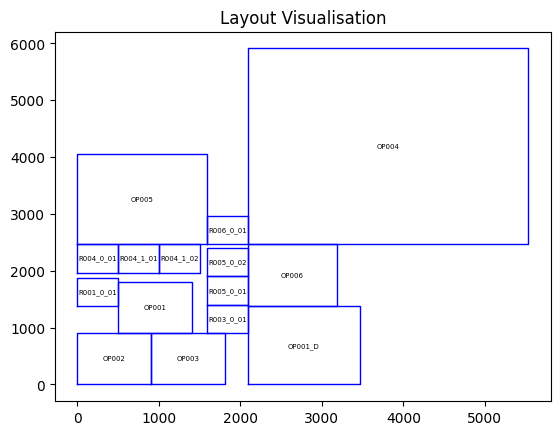

In [ ]:
generate_plot(n, final_x, final_y, l_val, w_val, final_pos, index_mapping)
print("Detailed placement information:")
for obj in index_mapping:
    print(f"{obj}: x_coordinate: {final_x[index_mapping[obj]]}, y-coordinate: {final_y[index_mapping[obj]]}")

In [ ]:
"""
ATTEMPT TO SPEED UP THE EXECUTION.
"""
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt
import plotly.graph_objects as go

def solve_modified(n, adj, l_actual, w_actual, anchors):
    # anchors, adj, l_val and w_val must all be 0-indexed.
    model = cp_model.CpModel()

    # Declaring the variables.
    maximum = sum([max(l_actual[index], w_actual[index]) for index in range(n)])
    x_val = [model.NewIntVar(0, maximum, f"x_val{index}") for index in range(n)]
    y_val = [model.NewIntVar(0, maximum, f"y_val{index}") for index in range(n)]

    # Adding the anchor-based constraints.
    x_max = model.NewIntVar(0, cp_model.INT32_MAX, "x_max")
    y_max = model.NewIntVar(0, cp_model.INT32_MAX, "y_max")
    for index in range(n):
        model.Add(x_max >= x_val[index] + l_actual[index])
        model.Add(y_max >= y_val[index] + w_actual[index])

    for index in anchors:
        bot = model.NewBoolVar("bot")
        top = model.NewBoolVar("top")
        left = model.NewBoolVar("left")
        right = model.NewBoolVar("right")
        model.Add(y_val[index] == 0).OnlyEnforceIf(bot)
        model.Add(x_val[index] == 0).OnlyEnforceIf(left)
        model.Add(x_val[index] >= x_max - l_actual[index]).OnlyEnforceIf(top)
        model.Add(y_val[index] >= y_max - w_actual[index]).OnlyEnforceIf(right)
        model.AddBoolOr([bot, top, left, right])

    # Only single anchor-based constraint added.
    # for index in anchors:
    #     model.Add(x_val[index] == 0)

    # Adding adjacency constraints.
    for i, j in adj:
        xji = model.NewBoolVar("xji")
        yji = model.NewBoolVar("yji")
        xij = model.NewBoolVar("xij")
        yij = model.NewBoolVar("yij")

        model.Add(x_val[j] == x_val[i] + l_actual[i]).OnlyEnforceIf(xji)
        model.Add(y_val[i] <= y_val[j]).OnlyEnforceIf(xji)
        model.Add(y_val[j] <= y_val[i] + w_actual[i]).OnlyEnforceIf(xji)

        model.Add(y_val[j] == y_val[i] + w_actual[i]).OnlyEnforceIf(yji)
        model.Add(x_val[i] <= x_val[j]).OnlyEnforceIf(yji)
        model.Add(x_val[j] <= x_val[i] + l_actual[i]).OnlyEnforceIf(yji)

        model.Add(x_val[i] == x_val[j] + l_actual[j]).OnlyEnforceIf(xij)
        model.Add(y_val[j] <= y_val[i]).OnlyEnforceIf(xij)
        model.Add(y_val[i] <= y_val[j] + w_actual[j]).OnlyEnforceIf(xij)

        model.Add(y_val[i] == y_val[j] + w_actual[j]).OnlyEnforceIf(yij)
        model.Add(x_val[j] <= x_val[i]).OnlyEnforceIf(yij)
        model.Add(x_val[i] <= x_val[j] + l_actual[j]).OnlyEnforceIf(yij)

        model.AddBoolOr([xji, yji, xij, yij])

    # Adding no-overlap constraints.
    for i in range(n):
        for j in range(i + 1, n):
            if [i, j] not in adj:
                xji = model.NewBoolVar("xji")
                yji = model.NewBoolVar("yji")
                xij = model.NewBoolVar("xij")
                yij = model.NewBoolVar("yij")
                model.Add(x_val[j] >= x_val[i] + l_actual[i]).OnlyEnforceIf(xji)
                model.Add(y_val[j] >= y_val[i] + w_actual[i]).OnlyEnforceIf(yji)
                model.Add(x_val[i] >= x_val[j] + l_actual[j]).OnlyEnforceIf(xij)
                model.Add(y_val[i] >= y_val[j] + w_actual[j]).OnlyEnforceIf(yij)
                model.AddBoolOr([xij, xji, yij, yji])

    # Efficient no-overlap constraint.
    # for i in range(n):
    #     for j in range(i + 1, n):
    #         if [i, j] not in adj:
    #             model.Add(x_val[i] + l_actual[i] <= x_val[j] | x_val[j] + l_actual[j] <= x_val[i])
    #             model.Add(y_val[i] + w_actual[i] <= y_val[j] | y_val[j] + w_actual[j] <= y_val[i])

    # Adding an objective function as well.
    # model.Minimize(x_max + y_max)

    # Create a solver and solve the model.
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    final_x, final_y, final_pos = [], [], []

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        for entry in x_val:
            final_x.append(solver.value(entry))
        for entry in y_val:
            final_y.append(solver.value(entry))
    else:
        print("No solution found.")

    return final_x, final_y, [1] * n

def generate_plot(n, final_x, final_y, l_val, w_val, index_mapping):
    for index in range(n):
        l = l_val[index]
        w = w_val[index]
        x_coords = [final_x[index], final_x[index] + l, final_x[index] + l, final_x[index], final_x[index]]
        y_coords = [final_y[index], final_y[index], final_y[index] + w, final_y[index] + w, final_y[index]]
        plt.plot(x_coords, y_coords, 'b-', linewidth=1)
        center_x = final_x[index] + l_val[index] / 2
        center_y = final_y[index] + w_val[index] / 2
        for name in index_mapping:
            if index_mapping[name] == index:
                break
        plt.text(center_x, center_y, name, ha="center", va="center", fontsize=5, color="black")

    plt.title("Layout Visualisation")
    plt.show()

def generate_plotly(n, final_x, final_y, l_val, w_val, index_mapping):
    # Create empty lists for storing traces
    traces = []
    texts = []
    for index in range(n):
        l = l_val[index]
        w = w_val[index]
        x_coords = [final_x[index], final_x[index] + l, final_x[index] + l, final_x[index], final_x[index]]
        y_coords = [final_y[index], final_y[index], final_y[index] + w, final_y[index] + w, final_y[index]]

        # Create a trace for the rectangle
        trace = go.Scatter(
            x=x_coords,
            y=y_coords,
            mode='lines', # Use 'lines' for rectangle outline
            fill='toself', # Fill the enclosed area
            fillcolor='rgba(200, 200, 200, 0.3)', # Set fill color with transparency
            line=dict(color='blue', width=1) # Set line color and width
        )
        traces.append(trace)

        center_x = final_x[index] + l_val[index] / 2
        center_y = final_y[index] + w_val[index] / 2

        # Find the corresponding name from the mapping
        name = [key for key, value in index_mapping.items() if value == index][0]

        # Create a text annotation for the rectangle center
        text = go.layout.Annotation(
            x=center_x,
            y=center_y,
            text=name,
            showarrow=False, # Hide the arrow
            textanchor="middle", # Align text horizontally
            valign="middle" # Align text vertically
        )
        texts.append(text)

    # Create the plotly figure with layout options
    fig = go.Figure(data=traces, layout=go.Layout(title="Layout Visualisation"))
    fig.update_layout(annotations=texts) # Add text annotations to the layout

    # Display the plot
    fig.show()


def get_data():
    n, index_mapping, l_val, w_val, adj, anchors = 0, dict(), [], [], [], []
    sizes = "/content/drive/My Drive/raman_solver/raman_solver_final/sizes.txt"
    anch = "/content/drive/My Drive/raman_solver/raman_solver_final/anchors.txt"
    edges = "/content/drive/My Drive/raman_solver/raman_solver_final/edges.txt"
    with open(sizes, "r") as file:
        for line in file:
            obj, size = line.strip().split(",")
            if obj not in index_mapping:
                index_mapping[obj] = n
                w_val.append(int(float(size)))
                l_val.append(int(float(size)))
                n += 1
    with open(anch, "r") as file:
        for line in file:
            obj = line.strip()
            index = index_mapping[obj]
            if index not in anchors:
                anchors.append(index)
    with open(edges, "r") as file:
        for line in file:
            obj1, obj2 = line.strip().split(",")
            idx1, idx2 = index_mapping[obj1], index_mapping[obj2]
            if idx1 > idx2:
                idx1, idx2 = idx2, idx1
            if [idx1, idx2] not in adj:
                adj.append([idx1, idx2])
    return n, index_mapping, l_val, w_val, adj, anchors

n, index_mapping, l_val, w_val, adj, anchors = get_data()
# n, index_mapping, l_val, w_val, adj, anchors = 3, {'0': 0, '1': 1, '2': 2}, [1, 2, 3], [1, 2, 3], [[0, 2]], [0, 2]
final_x, final_y, final_pos = solve_modified(n, adj, l_val, w_val, anchors)
generate_plot(n, final_x, final_y, l_val, w_val, index_mapping)
print("Detailed placement information:")
for obj in index_mapping:
    print(f"{obj}: Index: {index_mapping[obj]}, x_coordinate: {final_x[index_mapping[obj]]}, y-coordinate: {final_y[index_mapping[obj]]}")

No solution found.


IndexError: list index out of range

In [ ]:
"""
SPEED ACHIEVED, BUT UNABLE TO FIND OUT A SOLUTION.
"""
from ortools.sat.python import cp_model

def solve_modified(n, adj, l_val, w_val, anchors):
    # anchors, adj, l_val and w_val mist all be 0-indexed.
    model = cp_model.CpModel()

    # Declaring the variables.
    maximum = sum(l_val) + sum(w_val)
    pos = [model.NewBoolVar(f"pos{i}") for i in range(n)]

    for index in range(n):
        if(l_val[index] == w_val[index]):
            model.Add(pos[index] == 0)

    x_val = [model.NewIntVar(0, maximum, f"x_val{i}") for i in range(n)]
    y_val = [model.NewIntVar(0, maximum, f"y_val{i}") for i in range(n)]

    # Define length and width based on orientation
    maximum = sum(l_val) + sum(w_val)
    l_actual = [model.NewIntVar(0, maximum, f"l_actual{i}") for i in range(n)]
    w_actual = [model.NewIntVar(0, maximum, f"w_actual{i}") for i in range(n)]

    for i in range(n):
        model.Add(l_actual[i] == l_val[i]).OnlyEnforceIf(pos[i].Not())
        model.Add(l_actual[i] == w_val[i]).OnlyEnforceIf(pos[i])
        model.Add(w_actual[i] == w_val[i]).OnlyEnforceIf(pos[i].Not())
        model.Add(w_actual[i] == l_val[i]).OnlyEnforceIf(pos[i])

    # Adding the anchor-based constraints.
    maximum = sum(l_val) + sum(w_val)
    x_max = model.NewIntVar(0, maximum, "x_max")
    y_max = model.NewIntVar(0, maximum, "y_max")
    for index in range(n):
        model.Add(x_max >= x_val[index] + l_actual[index])
        model.Add(y_max >= y_val[index] + w_actual[index])

    for index in anchors:
        bot = model.NewBoolVar("bot")
        top = model.NewBoolVar("top")
        left = model.NewBoolVar("left")
        right = model.NewBoolVar("right")
        model.Add(y_val[index] == 0).OnlyEnforceIf(bot)
        model.Add(x_val[index] == 0).OnlyEnforceIf(left)
        model.Add(x_val[index] == x_max - l_actual[index]).OnlyEnforceIf(top)
        model.Add(y_val[index] == y_max - w_actual[index]).OnlyEnforceIf(right)
        model.AddBoolOr([bot, top, left, right])

    # Adding adjacency constraints.
    for i, j in adj:
        xji = model.NewBoolVar("xji")
        yji = model.NewBoolVar("yji")
        xij = model.NewBoolVar("xij")
        yij = model.NewBoolVar("yij")

        model.Add(x_val[j] == x_val[i] + l_actual[i]).OnlyEnforceIf(xji)
        model.Add(y_val[i] <= y_val[j]).OnlyEnforceIf(xji)
        model.Add(y_val[j] <= y_val[i] + w_actual[i]).OnlyEnforceIf(xji)

        model.Add(y_val[j] == y_val[i] + w_actual[i]).OnlyEnforceIf(yji)
        model.Add(x_val[i] <= x_val[j]).OnlyEnforceIf(yji)
        model.Add(x_val[j] <= x_val[i] + l_actual[i]).OnlyEnforceIf(yji)

        model.Add(x_val[i] == x_val[j] + l_actual[j]).OnlyEnforceIf(xij)
        model.Add(y_val[j] <= y_val[i]).OnlyEnforceIf(xij)
        model.Add(y_val[i] <= y_val[j] + w_actual[j]).OnlyEnforceIf(xij)

        model.Add(y_val[i] == y_val[j] + w_actual[j]).OnlyEnforceIf(yij)
        model.Add(x_val[j] <= x_val[i]).OnlyEnforceIf(yij)
        model.Add(x_val[i] <= x_val[j] + l_actual[j]).OnlyEnforceIf(yij)

        model.AddBoolOr([xji, yji, xij, yij])

    # Adding no-overlap constraints.
    for i in range(n):
        for j in range(i + 1, n):
            if [i, j] not in adj:
                xji = model.NewBoolVar("xji")
                yji = model.NewBoolVar("yji")
                xij = model.NewBoolVar("xij")
                yij = model.NewBoolVar("yij")
                model.add(x_val[j] >= x_val[i] + l_actual[i]).OnlyEnforceIf(xji)
                model.add(y_val[j] >= y_val[i] + w_actual[i]).OnlyEnforceIf(yji)
                model.add(x_val[i] >= x_val[j] + l_actual[j]).OnlyEnforceIf(xij)
                model.add(y_val[i] >= y_val[j] + w_actual[j]).OnlyEnforceIf(yij)
                model.AddBoolOr([xji, yji, xij, yij])

    model.Minimize(x_max + y_max)

    # Create a solver and solve the model.
    solver = cp_model.CpSolver()
    status = solver.solve(model)

    final_x, final_y, final_pos = [], [], []

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        for entry in x_val:
            final_x.append(solver.value(entry))
        for entry in y_val:
            final_y.append(solver.value(entry))
        for entry in pos:
            final_pos.append(solver.value(entry))
    else:
        print("No solution found.")

    return final_x, final_y, final_pos

def get_data():
    n, index_mapping, l_val, w_val, adj, anchors = 0, dict(), [], [], [], []
    sizes = "/content/drive/My Drive/raman_solver/raman_solver_final/sizes1.txt"
    anch = "/content/drive/My Drive/raman_solver/raman_solver_final/anchors1.txt"
    edges = "/content/drive/My Drive/raman_solver/raman_solver_final/edges1.txt"
    with open(sizes, "r") as file:
        for line in file:
            obj, length, breadth = line.strip().split(",")
            if obj not in index_mapping:
                index_mapping[obj] = n
                w_val.append(int(float(length)))
                l_val.append(int(float(breadth)))
                n += 1
    with open(anch, "r") as file:
        for line in file:
            obj = line.strip()
            index = index_mapping[obj]
            if index not in anchors:
                anchors.append(index)
    with open(edges, "r") as file:
        for line in file:
            obj1, obj2 = line.strip().split(",")
            idx1, idx2 = index_mapping[obj1], index_mapping[obj2]
            if idx1 > idx2:
                idx1, idx2 = idx2, idx1
            if [idx1, idx2] not in adj:
                adj.append([idx1, idx2])
    return n, index_mapping, l_val, w_val, adj, anchors

def generate_plot(n, final_x, final_y, l_val, w_val, index_mapping):
    for index in range(n):
        l = l_val[index]
        w = w_val[index]
        x_coords = [final_x[index], final_x[index] + l, final_x[index] + l, final_x[index], final_x[index]]
        y_coords = [final_y[index], final_y[index], final_y[index] + w, final_y[index] + w, final_y[index]]
        plt.plot(x_coords, y_coords, 'b-', linewidth=1)
        center_x = final_x[index] + l_val[index] / 2
        center_y = final_y[index] + w_val[index] / 2
        for name in index_mapping:
            if index_mapping[name] == index:
                break
        plt.text(center_x, center_y, name, ha="center", va="center", fontsize=5, color="black")

    plt.title("Layout Visualisation")
    plt.show()

n, index_mapping, l_val, w_val, adj, anchors = get_data()
# n, index_mapping, l_val, w_val, adj, anchors = 3, {'0': 0, '1': 1, '2': 2}, [1, 2, 3], [1, 2, 3], [[0, 2], [1, 2]], [0, 1, 2]
final_x, final_y, final_pos = solve_modified(n, adj, l_val, w_val, anchors)
print("Detailed placement information:")
for obj in index_mapping:
    print(f"{obj}: Index: {index_mapping[obj]}, x_coordinate: {final_x[index_mapping[obj]]}, y-coordinate: {final_y[index_mapping[obj]]}")

for index in range(n):
    if(final_pos[index] == 1):
        l_val[index], w_val[index] = w_val[index], l_val[index]

generate_plot(n, final_x, final_y, l_val, w_val, index_mapping)

No solution found.
Detailed placement information:


IndexError: list index out of range

In [ ]:
"""
BRAINSTORMING.
"""
from ortools.sat.python import cp_model
import plotly.graph_objects as go

def solve_modified(n, adj, l_val, w_val, anchors):
    # anchors, adj, l_val and w_val mist all be 0-indexed.
    model = cp_model.CpModel()

    # Declaring the variables.
    maximum = sum(l_val) + sum(w_val)
    pos = [model.NewBoolVar(f"pos{i}") for i in range(n)]

    for index in range(n):
        if(l_val[index] == w_val[index]):
            model.Add(pos[index] == 0)

    x_val = [model.NewIntVar(0, maximum, f"x_val{i}") for i in range(n)]
    y_val = [model.NewIntVar(0, maximum, f"y_val{i}") for i in range(n)]

    # Define length and width based on orientation
    maximum = max(max(l_val), max(w_val))
    l_actual = [model.NewIntVar(0, maximum, f"l_actual{i}") for i in range(n)]
    w_actual = [model.NewIntVar(0, maximum, f"w_actual{i}") for i in range(n)]

    for i in range(n):
        model.Add(l_actual[i] == l_val[i]).OnlyEnforceIf(pos[i].Not())
        model.Add(l_actual[i] == w_val[i]).OnlyEnforceIf(pos[i])
        model.Add(w_actual[i] == w_val[i]).OnlyEnforceIf(pos[i].Not())
        model.Add(w_actual[i] == l_val[i]).OnlyEnforceIf(pos[i])

    # Adding the anchor-based constraints.
    maximum = sum(l_val) + sum(w_val)
    x_max = model.NewIntVar(0, maximum, "x_max")
    y_max = model.NewIntVar(0, maximum, "y_max")
    for index in range(n):
        model.Add(x_max >= x_val[index] + l_actual[index])
        model.Add(y_max >= y_val[index] + w_actual[index])

    for index in anchors:
        bot = model.NewBoolVar("bot")
        top = model.NewBoolVar("top")
        left = model.NewBoolVar("left")
        right = model.NewBoolVar("right")
        model.Add(y_val[index] == 0).OnlyEnforceIf(bot)
        model.Add(x_val[index] == 0).OnlyEnforceIf(left)
        model.Add(x_val[index] == x_max - l_actual[index]).OnlyEnforceIf(top)
        model.Add(y_val[index] == y_max - w_actual[index]).OnlyEnforceIf(right)
        model.AddBoolOr([bot, top, left, right])

    threshold = 300
    # Adding adjacency constraints.
    for i, j in adj:
        xji = model.NewBoolVar("xji")
        yji = model.NewBoolVar("yji")
        xij = model.NewBoolVar("xij")
        yij = model.NewBoolVar("yij")

        model.Add(x_val[j] <= x_val[i] + l_actual[i] + threshold).OnlyEnforceIf(xji)
        #model.Add(x_val[j] >= x_val[i] + l_actual[i]).OnlyEnforceIf(xji)
        model.Add(y_val[i] <= y_val[j] + threshold).OnlyEnforceIf(xji)
        model.Add(y_val[j] <= y_val[i] + w_actual[i] + threshold).OnlyEnforceIf(xji)

        model.Add(y_val[j] <= y_val[i] + w_actual[i] + threshold).OnlyEnforceIf(yji)
        #model.Add(y_val[j] >= y_val[i] + w_actual[i]).OnlyEnforceIf(yji)
        model.Add(x_val[i] <= x_val[j] + threshold).OnlyEnforceIf(yji)
        model.Add(x_val[j] <= x_val[i] + l_actual[i] + threshold).OnlyEnforceIf(yji)

        model.Add(x_val[i] <= x_val[j] + l_actual[j] + threshold).OnlyEnforceIf(xij)
        #model.Add(x_val[i] >= x_val[j] + l_actual[j]).OnlyEnforceIf(xij)
        model.Add(y_val[j] <= y_val[i] + threshold).OnlyEnforceIf(xij)
        model.Add(y_val[i] <= y_val[j] + w_actual[j] + threshold).OnlyEnforceIf(xij)

        model.Add(y_val[i] <= y_val[j] + w_actual[j] + threshold).OnlyEnforceIf(yij)
        #model.Add(y_val[i] >= y_val[j] + w_actual[j]).OnlyEnforceIf(yij)
        model.Add(x_val[j] <= x_val[i] + threshold).OnlyEnforceIf(yij)
        model.Add(x_val[i] <= x_val[j] + l_actual[j] + threshold).OnlyEnforceIf(yij)

        model.AddBoolOr([xji, yji, xij, yij])

    # Adding no-overlap constraints.
    for i in range(n):
        for j in range(i + 1, n):
            xji = model.NewBoolVar("xji")
            yji = model.NewBoolVar("yji")
            xij = model.NewBoolVar("xij")
            yij = model.NewBoolVar("yij")
            model.add(x_val[j] >= x_val[i] + l_actual[i]).OnlyEnforceIf(xji)
            model.add(y_val[j] >= y_val[i] + w_actual[i]).OnlyEnforceIf(yji)
            model.add(x_val[i] >= x_val[j] + l_actual[j]).OnlyEnforceIf(xij)
            model.add(y_val[i] >= y_val[j] + w_actual[j]).OnlyEnforceIf(yij)
            model.AddBoolOr([xji, yji, xij, yij])

    model.Minimize(x_max + y_max)

    # Create a solver and solve the model.
    solver = cp_model.CpSolver()
    status = solver.solve(model)

    final_x, final_y, final_pos = [], [], []

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        for entry in x_val:
            final_x.append(solver.value(entry))
        for entry in y_val:
            final_y.append(solver.value(entry))
        for entry in pos:
            final_pos.append(solver.value(entry))
    else:
        print("No solution found.")

    return final_x, final_y, final_pos

def get_data():
    n, index_mapping, l_val, w_val, adj, anchors = 0, dict(), [], [], [], []
    sizes = "/content/drive/My Drive/raman_solver/raman_solver_final/sizes1.txt"
    anch = "/content/drive/My Drive/raman_solver/raman_solver_final/anchors1.txt"
    edges = "/content/drive/My Drive/raman_solver/raman_solver_final/edges1.txt"
    with open(sizes, "r") as file:
        for line in file:
            obj, length, breadth = line.strip().split(",")
            if obj not in index_mapping:
                index_mapping[obj] = n
                w_val.append(int(float(length)))
                l_val.append(int(float(breadth)))
                n += 1
    with open(anch, "r") as file:
        for line in file:
            obj = line.strip()
            index = index_mapping[obj]
            if index not in anchors:
                anchors.append(index)
    with open(edges, "r") as file:
        for line in file:
            obj1, obj2 = line.strip().split(",")
            idx1, idx2 = index_mapping[obj1], index_mapping[obj2]
            if idx1 > idx2:
                idx1, idx2 = idx2, idx1
            if [idx1, idx2] not in adj:
                adj.append([idx1, idx2])
    return n, index_mapping, l_val, w_val, adj, anchors

def generate_plot(n, final_x, final_y, l_val, w_val, index_mapping):
    fig = go.Figure()

    for index in range(n):
        l = l_val[index]
        w = w_val[index]
        x_coords = [final_x[index], final_x[index] + l, final_x[index] + l, final_x[index], final_x[index]]
        y_coords = [final_y[index], final_y[index], final_y[index] + w, final_y[index] + w, final_y[index]]

        # Add rectangle (as a closed loop of coordinates)
        fig.add_trace(go.Scatter(
            x=x_coords,
            y=y_coords,
            mode='lines',
            line=dict(color='blue', width=1)
        ))

        # Find the center for text annotation
        center_x = final_x[index] + l_val[index] / 2
        center_y = final_y[index] + w_val[index] / 2

        # Find the name corresponding to the index
        for name in index_mapping:
            if index_mapping[name] == index:
                break

        # Add text annotation at the center of the rectangle
        fig.add_trace(go.Scatter(
            x=[center_x],
            y=[center_y],
            text=[name],
            mode='text',
            textfont=dict(size=12, color='black'),
            showlegend=False
        ))

    fig.update_layout(
        title='Layout Visualisation',
        xaxis=dict(title='X-axis'),
        yaxis=dict(title='Y-axis'),
        showlegend=False
    )

    fig.show()

n, index_mapping, l_val, w_val, adj, anchors = get_data()
#n, index_mapping, l_val, w_val, adj, anchors = 3, {'0': 0, '1': 1, '2': 2}, [1, 2, 3], [1, 2, 3], [[0, 2], [1, 2]], [0, 1, 2]
final_x, final_y, final_pos = solve_modified(n, adj, l_val, w_val, anchors)
print("Detailed placement information:")
for obj in index_mapping:
    print(f"{obj}: Index: {index_mapping[obj]}, x_coordinate: {final_x[index_mapping[obj]]}, y-coordinate: {final_y[index_mapping[obj]]}")

for index in range(n):
    if(final_pos[index] == 1):
        l_val[index], w_val[index] = w_val[index], l_val[index]

generate_plot(n, final_x, final_y, l_val, w_val, index_mapping)

Detailed placement information:
R001_0_01: Index: 0, x_coordinate: 4417, y-coordinate: 9814
OP001: Index: 1, x_coordinate: 4117, y-coordinate: 2530
R002_0_01: Index: 2, x_coordinate: 12567, y-coordinate: 2437
OP002: Index: 3, x_coordinate: 19603, y-coordinate: 2140
R003_0_01: Index: 4, x_coordinate: 6627, y-coordinate: 7554
OP003: Index: 5, x_coordinate: 5927, y-coordinate: 7554
R004_0_01: Index: 6, x_coordinate: 5327, y-coordinate: 2587
OP004: Index: 7, x_coordinate: 0, y-coordinate: 3887
R004_0_02: Index: 8, x_coordinate: 1000, y-coordinate: 0
R004_1_01: Index: 9, x_coordinate: 0, y-coordinate: 2887
R004_1_02: Index: 10, x_coordinate: 0, y-coordinate: 0
R004_01_0_01: Index: 11, x_coordinate: 5927, y-coordinate: 8572
OP004_01: Index: 12, x_coordinate: 19603, y-coordinate: 7854
R005_0_01: Index: 13, x_coordinate: 9060, y-coordinate: 0
OP005: Index: 14, x_coordinate: 7749, y-coordinate: 6474
R005_1_01: Index: 15, x_coordinate: 9060, y-coordinate: 1000
R005_1_02: Index: 16, x_coordinate:

In [ ]:
!pip install ortools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.2/309.2 kB 26.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires protobuf<5,>=3.20, but you have protobuf 5.27.0 which is incompatible.
google-ai-generativelanguage 0.6.4 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have proto

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
"""
BRAINSTORMING.
"""
from ortools.sat.python import cp_model
import plotly.graph_objects as go

def solve_modified(n, adj, l_val, w_val, anchors):
    # anchors, adj, l_val and w_val mist all be 0-indexed.
    model = cp_model.CpModel()

    # Declaring the variables.
    maximum = sum(l_val) + sum(w_val)
    pos = [model.NewBoolVar(f"pos{i}") for i in range(n)]

    for index in range(n):
        if(l_val[index] == w_val[index]):
            model.Add(pos[index] == 0)

    x_val = [model.NewIntVar(0, maximum, f"x_val{i}") for i in range(n)]
    y_val = [model.NewIntVar(0, maximum, f"y_val{i}") for i in range(n)]

    # Define length and width based on orientation
    maximum = max(max(l_val), max(w_val))
    l_actual = [model.NewIntVar(0, maximum, f"l_actual{i}") for i in range(n)]
    w_actual = [model.NewIntVar(0, maximum, f"w_actual{i}") for i in range(n)]

    for i in range(n):
        model.Add(l_actual[i] == l_val[i]).OnlyEnforceIf(pos[i].Not())
        model.Add(l_actual[i] == w_val[i]).OnlyEnforceIf(pos[i])
        model.Add(w_actual[i] == w_val[i]).OnlyEnforceIf(pos[i].Not())
        model.Add(w_actual[i] == l_val[i]).OnlyEnforceIf(pos[i])

    # Adding the anchor-based constraints.
    maximum = sum(l_val) + sum(w_val)
    x_max = model.NewIntVar(0, maximum, "x_max")
    y_max = model.NewIntVar(0, maximum, "y_max")
    for index in range(n):
        model.Add(x_max >= x_val[index] + l_actual[index])
        model.Add(y_max >= y_val[index] + w_actual[index])

    for index in anchors:
        bot = model.NewBoolVar("bot")
        #top = model.NewBoolVar("top")
        left = model.NewBoolVar("left")
        #right = model.NewBoolVar("right")
        model.Add(y_val[index] == 0).OnlyEnforceIf(bot)
        model.Add(x_val[index] == 0).OnlyEnforceIf(left)
        #model.Add(x_val[index] == x_max - l_actual[index]).OnlyEnforceIf(top)
        #model.Add(y_val[index] == y_max - w_actual[index]).OnlyEnforceIf(right)
        model.AddBoolOr([bot, left])

    threshold = 700
    # Adding adjacency constraints.
    for i, j in adj:
        xji = model.NewBoolVar("xji")
        yji = model.NewBoolVar("yji")
        xij = model.NewBoolVar("xij")
        yij = model.NewBoolVar("yij")

        model.Add(x_val[j] <= x_val[i] + l_actual[i] + threshold).OnlyEnforceIf(xji)
        model.Add(x_val[j] >= x_val[i] + l_actual[i]).OnlyEnforceIf(xji)
        for index in range(n):
            if(index != i and index != j):
                x11 = model.NewBoolVar("x11")
                x12 = model.NewBoolVar("x12")
                x13 = model.NewBoolVar("x13")
                x14 = model.NewBoolVar("x14")
                model.Add(y_val[index] >= y_val[i] + w_actual[i] + threshold).OnlyEnforceIf(x11)
                model.Add(y_val[index] + w_actual[index] <= y_val[i] - threshold).OnlyEnforceIf(x12)
                model.Add(x_val[index] + l_actual[index] <= x_val[i] + l_actual[i]).OnlyEnforceIf(x13)
                model.Add(x_val[index] >= x_val[i] + l_actual[i] + threshold).OnlyEnforceIf(x14)
                model.AddBoolOr([x11, x12, x13, x14]).OnlyEnforceIf(xji)
        model.Add(y_val[i] <= y_val[j] + threshold).OnlyEnforceIf(xji)
        model.Add(y_val[j] <= y_val[i] + w_actual[i] + threshold).OnlyEnforceIf(xji)

        model.Add(y_val[j] <= y_val[i] + w_actual[i] + threshold).OnlyEnforceIf(yji)
        model.Add(y_val[j] >= y_val[i] + w_actual[i]).OnlyEnforceIf(yji)
        for index in range(n):
            if(index != i and index != j):
                y11 = model.NewBoolVar("y11")
                y12 = model.NewBoolVar("y12")
                y13 = model.NewBoolVar("y13")
                y14 = model.NewBoolVar("y14")
                model.Add(x_val[index] >= x_val[i] + l_actual[i] + threshold).OnlyEnforceIf(y11)
                model.Add(x_val[index] + l_actual[index] <= x_val[i] - threshold).OnlyEnforceIf(y12)
                model.Add(y_val[index] + w_actual[index] <= y_val[i] + w_actual[i]).OnlyEnforceIf(y13)
                model.Add(y_val[index] >= y_val[i] + w_actual[i] + threshold).OnlyEnforceIf(y14)
                model.AddBoolOr([y11, y12, y13, y14]).OnlyEnforceIf(yji)
        model.Add(x_val[i] <= x_val[j] + threshold).OnlyEnforceIf(yji)
        model.Add(x_val[j] <= x_val[i] + l_actual[i] + threshold).OnlyEnforceIf(yji)

        model.Add(x_val[i] <= x_val[j] + l_actual[j] + threshold).OnlyEnforceIf(xij)
        model.Add(x_val[i] >= x_val[j] + l_actual[j]).OnlyEnforceIf(xij)
        for index in range(n):
            if(index != i and index != j):
                x21 = model.NewBoolVar("x21")
                x22 = model.NewBoolVar("x22")
                x23 = model.NewBoolVar("x23")
                x24 = model.NewBoolVar("x24")
                model.Add(y_val[index] >= y_val[j] + w_actual[j] + threshold).OnlyEnforceIf(x21)
                model.Add(y_val[index] + w_actual[index] <= y_val[j] - threshold).OnlyEnforceIf(x22)
                model.Add(x_val[index] + l_actual[index] <= x_val[j] + l_actual[j]).OnlyEnforceIf(x23)
                model.Add(x_val[index] >= x_val[j] + l_actual[j] + threshold).OnlyEnforceIf(x24)
                model.AddBoolOr([x21, x22, x23, x24]).OnlyEnforceIf(xij)
        model.Add(y_val[j] <= y_val[i] + threshold).OnlyEnforceIf(xij)
        model.Add(y_val[i] <= y_val[j] + w_actual[j] + threshold).OnlyEnforceIf(xij)

        model.Add(y_val[i] <= y_val[j] + w_actual[j] + threshold).OnlyEnforceIf(yij)
        model.Add(y_val[i] >= y_val[j] + w_actual[j]).OnlyEnforceIf(yij)
        for index in range(n):
            if(index != i and index != j):
                y21 = model.NewBoolVar("y21")
                y22 = model.NewBoolVar("y22")
                y23 = model.NewBoolVar("y23")
                y24 = model.NewBoolVar("y24")
                model.Add(x_val[index] >= x_val[j] + l_actual[j] + threshold).OnlyEnforceIf(y21)
                model.Add(x_val[index] + l_actual[index] <= x_val[j] - threshold).OnlyEnforceIf(y22)
                model.Add(y_val[index] + w_actual[index] <= y_val[j] + w_actual[j]).OnlyEnforceIf(y23)
                model.Add(y_val[index] >= y_val[j] + w_actual[j] + threshold).OnlyEnforceIf(y24)
                model.AddBoolOr([y21, y22, y23, y24]).OnlyEnforceIf(yij)
        model.Add(x_val[j] <= x_val[i] + threshold).OnlyEnforceIf(yij)
        model.Add(x_val[i] <= x_val[j] + l_actual[j] + threshold).OnlyEnforceIf(yij)

        model.AddBoolOr([xji, yji, xij, yij])

    # Adding no-overlap constraints.
    for i in range(n):
        for j in range(i + 1, n):
            xji = model.NewBoolVar("xji")
            yji = model.NewBoolVar("yji")
            xij = model.NewBoolVar("xij")
            yij = model.NewBoolVar("yij")
            model.add(x_val[j] >= x_val[i] + l_actual[i]).OnlyEnforceIf(xji)
            model.add(y_val[j] >= y_val[i] + w_actual[i]).OnlyEnforceIf(yji)
            model.add(x_val[i] >= x_val[j] + l_actual[j]).OnlyEnforceIf(xij)
            model.add(y_val[i] >= y_val[j] + w_actual[j]).OnlyEnforceIf(yij)
            model.AddBoolOr([xji, yji, xij, yij])

    model.Minimize(x_max + y_max)

    # Create a solver and solve the model.
    solver = cp_model.CpSolver()
    status = solver.solve(model)

    final_x, final_y, final_pos = [], [], []

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        for entry in x_val:
            final_x.append(solver.value(entry))
        for entry in y_val:
            final_y.append(solver.value(entry))
        for entry in pos:
            final_pos.append(solver.value(entry))
    else:
        print("No solution found.")

    return final_x, final_y, final_pos

def get_data():
    n, index_mapping, l_val, w_val, adj, anchors = 0, dict(), [], [], [], []
    sizes = "/content/drive/My Drive/raman_solver/raman_solver_final/sizes.txt"
    anch = "/content/drive/My Drive/raman_solver/raman_solver_final/anchors.txt"
    edges = "/content/drive/My Drive/raman_solver/raman_solver_final/edges.txt"
    with open(sizes, "r") as file:
        for line in file:
            obj, length, breadth = line.strip().split(",")
            if obj not in index_mapping:
                index_mapping[obj] = n
                w_val.append(int(float(length)))
                l_val.append(int(float(breadth)))
                n += 1
    with open(anch, "r") as file:
        for line in file:
            obj = line.strip()
            index = index_mapping[obj]
            if index not in anchors:
                anchors.append(index)
    with open(edges, "r") as file:
        for line in file:
            obj1, obj2 = line.strip().split(",")
            idx1, idx2 = index_mapping[obj1], index_mapping[obj2]
            if idx1 > idx2:
                idx1, idx2 = idx2, idx1
            if [idx1, idx2] not in adj:
                adj.append([idx1, idx2])
    return n, index_mapping, l_val, w_val, adj, anchors

def generate_plot(n, final_x, final_y, l_val, w_val, index_mapping):
    fig = go.Figure()

    for index in range(n):
        l = l_val[index]
        w = w_val[index]
        x_coords = [final_x[index], final_x[index] + l, final_x[index] + l, final_x[index], final_x[index]]
        y_coords = [final_y[index], final_y[index], final_y[index] + w, final_y[index] + w, final_y[index]]

        # Add rectangle (as a closed loop of coordinates)
        fig.add_trace(go.Scatter(
            x=x_coords,
            y=y_coords,
            mode='lines',
            line=dict(color='blue', width=1)
        ))

        # Find the center for text annotation
        center_x = final_x[index] + l_val[index] / 2
        center_y = final_y[index] + w_val[index] / 2

        # Find the name corresponding to the index
        for name in index_mapping:
            if index_mapping[name] == index:
                break

        # Add text annotation at the center of the rectangle
        fig.add_trace(go.Scatter(
            x=[center_x],
            y=[center_y],
            text=[name],
            mode='text',
            textfont=dict(size=12, color='black'),
            showlegend=False
        ))

    fig.update_layout(
        title='Layout Visualisation',
        xaxis=dict(title='X-axis'),
        yaxis=dict(title='Y-axis'),
        showlegend=False
    )

    return fig

n, index_mapping, l_val, w_val, adj, anchors = get_data()
final_x, final_y, final_pos = solve_modified(n, adj, l_val, w_val, anchors)

for index in range(n):
    if(final_pos[index] == 1):
        l_val[index], w_val[index] = w_val[index], l_val[index]

Plot saved as /content/drive/My Drive/raman_solver/raman_solver_final/final_plot.html


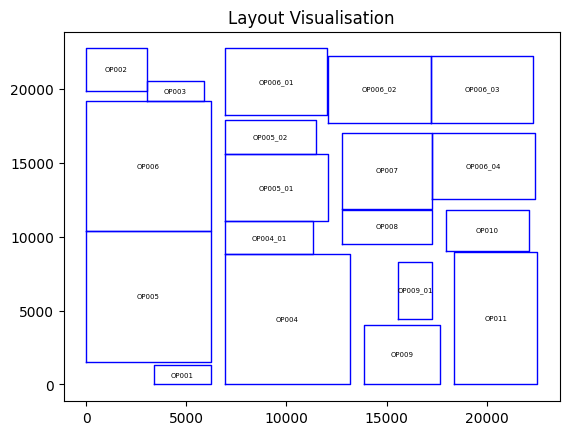

In [6]:
import matplotlib.pyplot as plt
def save_plot_as_html(fig, filename="/content/drive/My Drive/raman_solver/raman_solver_final/final_plot.html"):
    fig.write_html(filename)
    print(f"Plot saved as {filename}")

def generate_plot_matplot(n, final_x, final_y, l_val, w_val, index_mapping):
    for index in range(n):
        l = l_val[index]
        w = w_val[index]
        x_coords = [final_x[index], final_x[index] + l, final_x[index] + l, final_x[index], final_x[index]]
        y_coords = [final_y[index], final_y[index], final_y[index] + w, final_y[index] + w, final_y[index]]
        plt.plot(x_coords, y_coords, 'b-', linewidth=1)
        center_x = final_x[index] + l_val[index] / 2
        center_y = final_y[index] + w_val[index] / 2
        for name in index_mapping:
            if index_mapping[name] == index:
                break
        plt.text(center_x, center_y, name, ha="center", va="center", fontsize=5, color="black")

    plt.title("Layout Visualisation")
    # plt.show()
    plt.savefig("/content/drive/My Drive/raman_solver/raman_solver_final/scaled.png")

save_plot_as_html(generate_plot(n, final_x, final_y, l_val, w_val, index_mapping))
generate_plot_matplot(n, final_x, final_y, l_val, w_val, index_mapping)